In [85]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN, EffectiveDimension
from qiskit_machine_learning.connectors import TorchConnector
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli

In [86]:
def get_data() : 
    X, y = make_moons(n_samples=400, noise=0.2, random_state=42)
    return train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
def build_qnn(n_qubits=2) : 
    fmap = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1, entanglement='linear')
    qc = QuantumCircuit(n_qubits)
    qc.compose(fmap, inplace=True)
    qc.compose(ansatz, inplace=True)

    observables = [SparsePauliOp('Z' * 2), SparsePauliOp('X' * 2)]

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=fmap.parameters,
        weight_params=ansatz.parameters,
        observables=observables,
        estimator=Estimator()
    )
    return TorchConnector(qnn), qnn

In [138]:
def compute_gradient_variance(model, criterion, X, y) : 
    grads = []
    for i in range(len(X)) : 
        model.zero_grad()
        output = model(X[i].unsqueeze(0))
        loss = criterion(output, y[i].unsqueeze(0))
        loss.backward()
        flat_grads = torch.cat([p.grad.view(-1) for p in model.parameters()])
        grads.append(flat_grads.detach().cpu().numpy())

    grads = np.array(grads)
    mean_grad = np.mean(grads, axis=0, keepdims=True)
    centered = grads - mean_grad

    cov_matrix = centered.T @ centered / len(grads)

    grad_var = np.trace(cov_matrix)
    return grad_var

In [144]:
def compute_effective_dimension(qnn, X, n_weights, dataset_size=200) : 
    ed = EffectiveDimension(qnn=qnn, weight_samples=n_weights, input_samples=X)
    return ed.get_effective_dimension(dataset_size=dataset_size)

def train_and_track() : 
    X_train, X_test, y_train, y_test = get_data()
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    model, qnn = build_qnn(n_qubits=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)

    gv_list, ed_list, acc_list = [], [], []

    for epoch in range(10) : 
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad() : 
            test_output = model(X_test)
            pred = torch.argmax(test_output, dim=1)
            acc = accuracy_score(y_test.numpy(), pred.numpy())

        gv = compute_gradient_variance(model, criterion, X_train, y_train)
        temp = []
        for _ in range(5) : 
            ed = compute_effective_dimension(qnn, X_train.numpy(), n_weights=len(list(model.parameters())[0].flatten()))
            temp.append(ed)
        temp = np.array(temp)
        ed = np.mean(temp)

        gv_list.append(gv)
        ed_list.append(ed)
        acc_list.append(acc)

    return gv_list, ed_list, acc_list

In [145]:
def plot_metrics(gv_list, ed_list, acc_list) : 
    epochs_gv = list(range(len(gv_list)))
    epochs_ed = list(range(len(ed_list)))
    epochs_acc = list(range(len(acc_list)))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_gv, gv_list, label='Gradient Variance')
    plt.xlabel('Epoch')
    plt.ylabel('GV')
    plt.title('Gradient Variance')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_ed, ed_list, label='Effective Dimension', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('ED')
    plt.title('Effective Dimension')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_acc, acc_list, label='Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()

/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_12787/2622494151.py:15: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator()
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_12787/2622494151.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


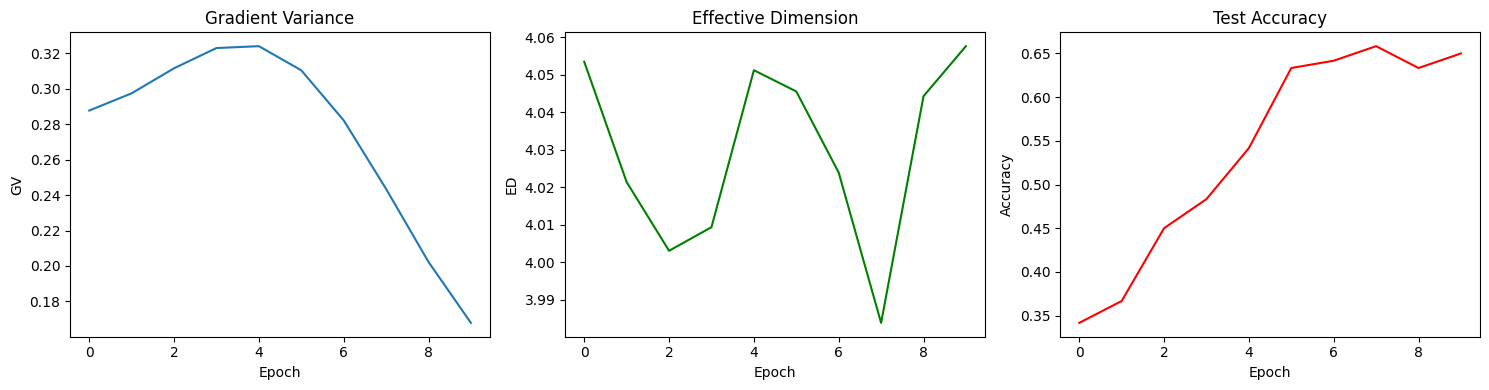

In [146]:
gv_list, ed_list, acc_list = train_and_track()
plot_metrics(gv_list, ed_list, acc_list)

In [147]:
def plot_metrics_(gv_list, ed_list, acc_list) : 
    epochs_gv = list(range(len(gv_list)))
    epochs_ed = list(range(len(ed_list)))
    epochs_acc = list(range(len(acc_list)))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    gv_array = np.array(gv_list)
    inverse_gv_array = 1 / gv_array
    inverse_gv_norm = (inverse_gv_array - np.min(inverse_gv_array)) / (np.max(inverse_gv_array) - np.min(inverse_gv_array))
    plt.plot(epochs_gv, inverse_gv_norm, label='Inverse Gradient Variance (scaled)')
    plt.xlabel('Epoch')
    plt.ylabel('Inverse GV (scaled)')
    plt.title('Inverse Gradient Variance (scaled)')

    plt.subplot(1, 3, 2)
    ed_array = np.array(ed_list)
    ed_norm = (ed_array - np.min(ed_array)) / (np.max(ed_array) - np.min(ed_array))
    plt.plot(epochs_ed, ed_norm, label='Effective Dimension', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('ED')
    plt.title('Effective Dimension')

    plt.subplot(1, 3, 3)
    acc_array = np.array(acc_list)
    acc_norm = (acc_array - np.min(acc_array)) / (np.max(acc_array) - np.min(acc_array))
    plt.plot(epochs_acc, acc_norm, label='Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()

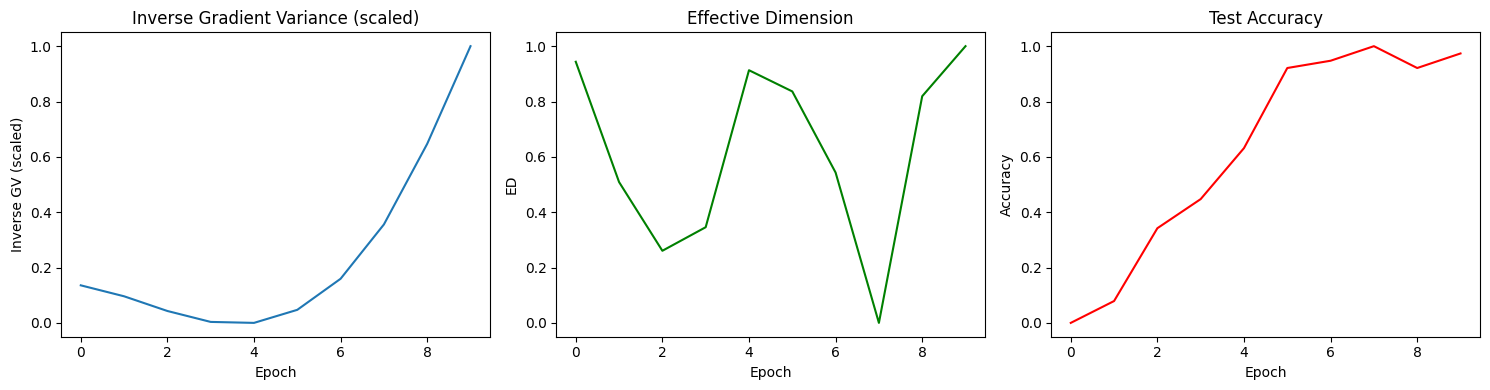

In [148]:
plot_metrics_(gv_list, ed_list, acc_list)